In [93]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [94]:
df=pd.read_csv("Alcohol sales.csv")


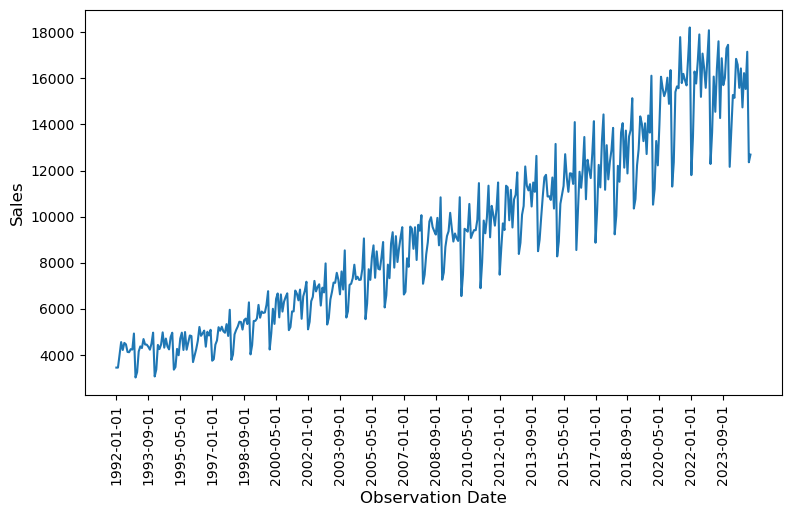

In [158]:
#Visualization of data to see the Trend and get a sense of what is going on
##Make a Plot
plt.figure(figsize = (9,5))
##Define Feature and Target for the plot
plt.plot(df['observation_date'], df['S4248SM144NCEN'])
plt.xlabel('Observation Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
#### Add Xticks with step of 20
plt.xticks(np.arange(0,df.shape[0],20), rotation = 90)
plt.show()

In [160]:

shape= df.shape
print(f"Dataset size of Dates: {shape[0]} ")
### 398-2=396 (Datas are repeated in 12 day sequences except two datas at the end of dataset)
#### 396/12=33 , we take 23 sets as train and 10 sets as test (Train= 23*12=276, Test=10*12=120)
Train_dataset=df.iloc[:376]

Train_X=Train_dataset['S4248SM144NCEN'].values
Train_X = torch.from_numpy(Train_X).to(dtype=torch.float32)
#####Scaling to avoid exploding gradients
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(Train_X.reshape(-1,1))
X_scaled=torch.from_numpy(X_scaled).to(dtype=torch.float32)

Dataset size of Dates: 398 


In [161]:
###Creating windows
def make_window(seq, ws):
    out = []
    L = len(seq)

    # Ensuring input is a flat tensor
    seq = seq.flatten()
###predictions of simple scale of windows on large scale data points are not good.
#Relative scaling improves high magnitude predictions by focusing the model on how values change relative to each other over time,
#  rather than the raw magnitude of the values 
    for i in range(L - ws - 1):
        base = seq[i]  # first value of the window
        window_raw = seq[i:i + ws]
        label_raw = seq[i + ws]

        # Relative normalization
        window = ((window_raw / base) - 1.0).float()
        label = ((label_raw / base) - 1.0).float().unsqueeze(0)

        out.append((window, label))
    
    return out


In [162]:
import torch
import torch.nn as nn
##To avoid saturation of activation functions in LSTM blocks we add leaky-relu.
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, negative_slope=0.01):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=False)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=False)

        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)
        self.linear = nn.Linear(hidden_size, output_size)

        self.apply(self._init_weights)
###Initialization of weights.
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                m.bias.data.fill_(0.01)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)

    def forward(self, seq):
        h0_1 = torch.zeros(1, 1, self.hidden_size)
        c0_1 = torch.zeros(1, 1, self.hidden_size)
        h0_2 = torch.zeros(1, 1, self.hidden_size)
        c0_2 = torch.zeros(1, 1, self.hidden_size)

        out1, _ = self.lstm1(seq.view(len(seq), 1, -1), (h0_1, c0_1))
        out2, _ = self.lstm2(out1, (h0_2, c0_2))

        out2 = self.leaky_relu(out2)
        pred = self.linear(out2[-1])
        return pred


# Create model
model = LSTM()
##Learning rate is chosen by trial and error.
# Loss and optimizer
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)


In [81]:
print(train[-1:])

[(tensor([[0.7749],
        [0.7759],
        [0.7601],
        [0.8563],
        [0.7234]]), tensor([[1.]]))]


Epoch 1, Predicting loss improved to 0.060731
Epoch 2, Predicting loss improved to 0.060354
Epoch 3, Predicting loss improved to 0.058763
Epoch 5, Predicting loss improved to 0.055115
Epoch 6, Predicting loss improved to 0.051931
Epoch 8, Predicting loss improved to 0.047073
Epoch 9, Predicting loss improved to 0.046980
Epoch 10/150, Train Loss: 0.001455, Forecasted data's Loss: 0.048075


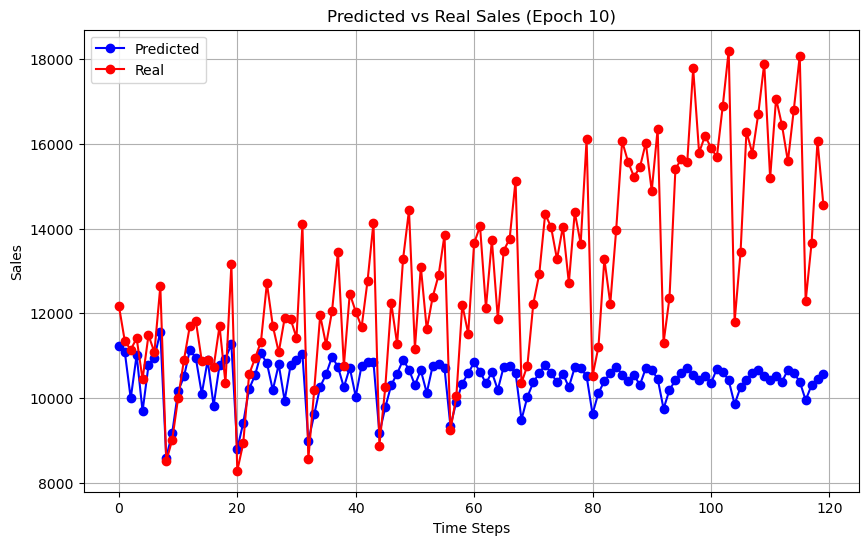

Epoch 11, Predicting loss improved to 0.044450
Epoch 13, Predicting loss improved to 0.042783
Epoch 15, Predicting loss improved to 0.039276
Epoch 16, Predicting loss improved to 0.037354
Epoch 18, Predicting loss improved to 0.037068
Epoch 20, Predicting loss improved to 0.028144
Epoch 20/150, Train Loss: 0.001406, Forecasted data's Loss: 0.028144


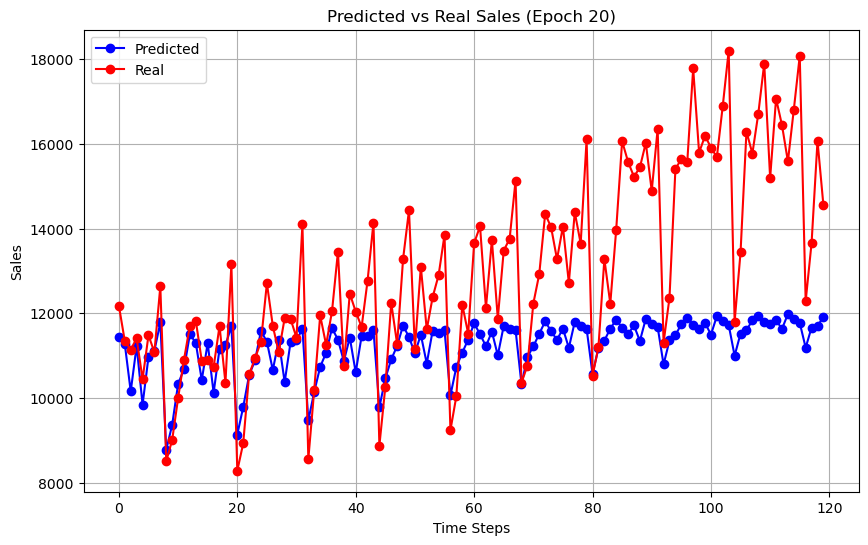

Epoch 27, Predicting loss improved to 0.025650
Epoch 28, Predicting loss improved to 0.023718
Epoch 29, Predicting loss improved to 0.020875
Epoch 30/150, Train Loss: 0.001346, Forecasted data's Loss: 0.022388


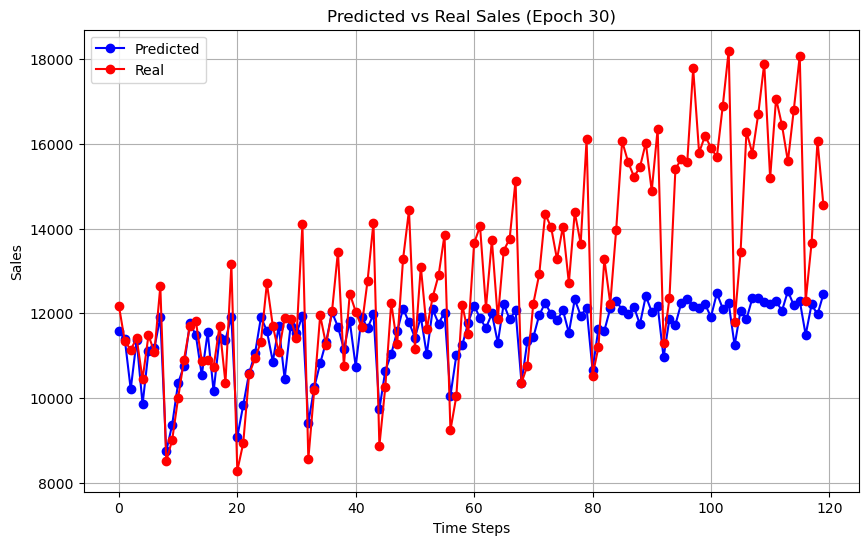

Epoch 34, Predicting loss improved to 0.020543
Epoch 40/150, Train Loss: 0.001272, Forecasted data's Loss: 0.030357


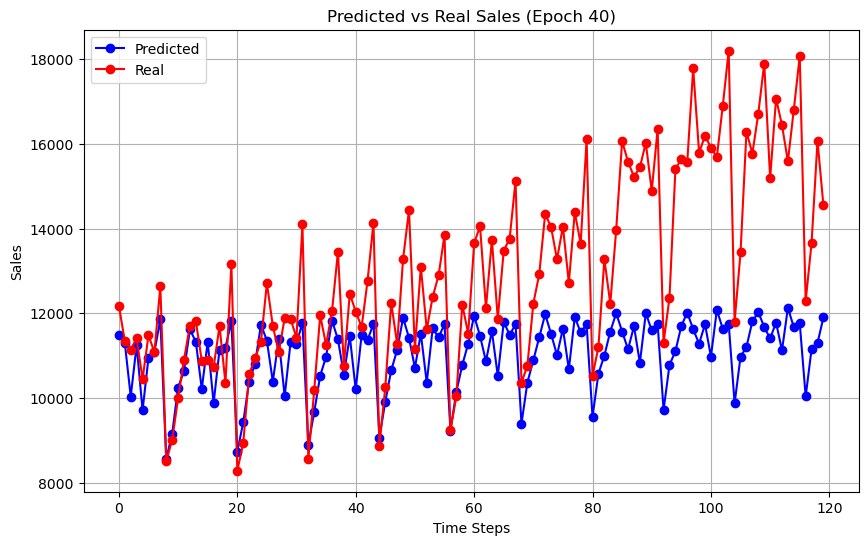

Epoch 50, Predicting loss improved to 0.020259
Epoch 50/150, Train Loss: 0.001245, Forecasted data's Loss: 0.020259


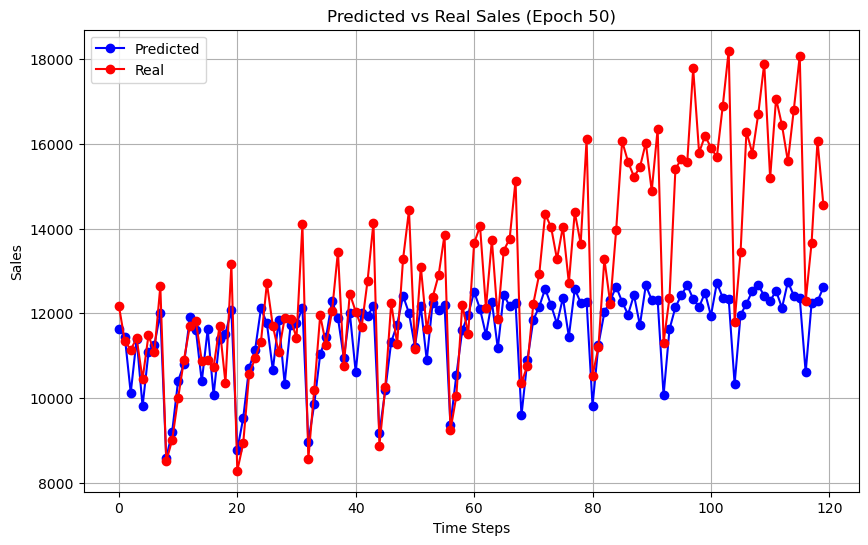

Epoch 51, Predicting loss improved to 0.019684
Epoch 52, Predicting loss improved to 0.018994
Epoch 53, Predicting loss improved to 0.018934
Epoch 60/150, Train Loss: 0.001145, Forecasted data's Loss: 0.024165


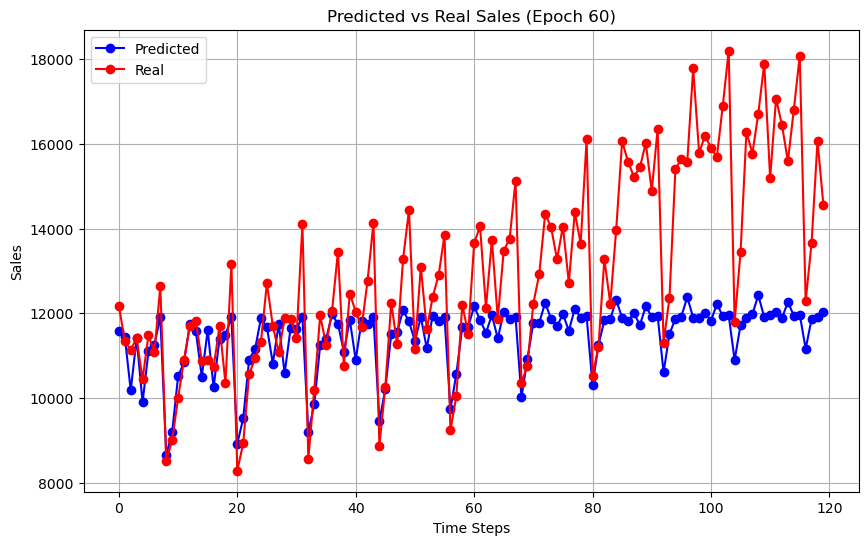

Epoch 70/150, Train Loss: 0.001118, Forecasted data's Loss: 0.027622


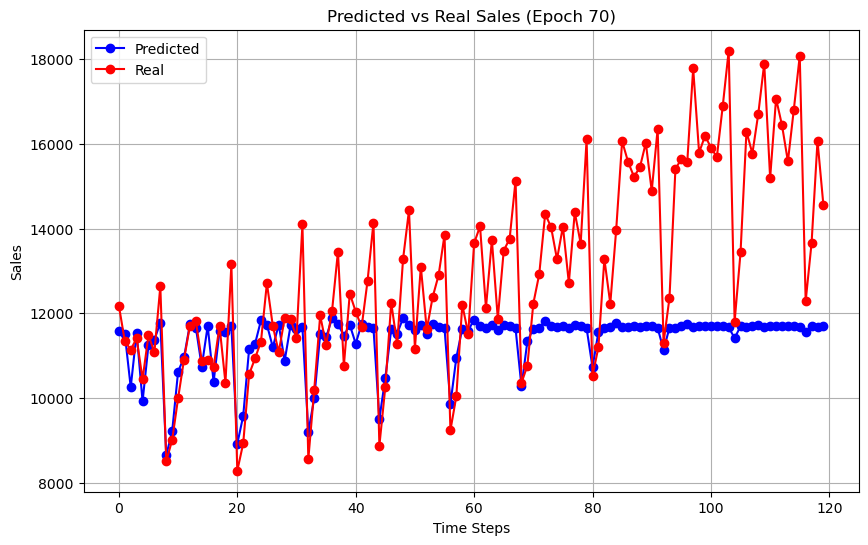

Epoch 72, Predicting loss improved to 0.017577
Epoch 80/150, Train Loss: 0.001196, Forecasted data's Loss: 0.026451


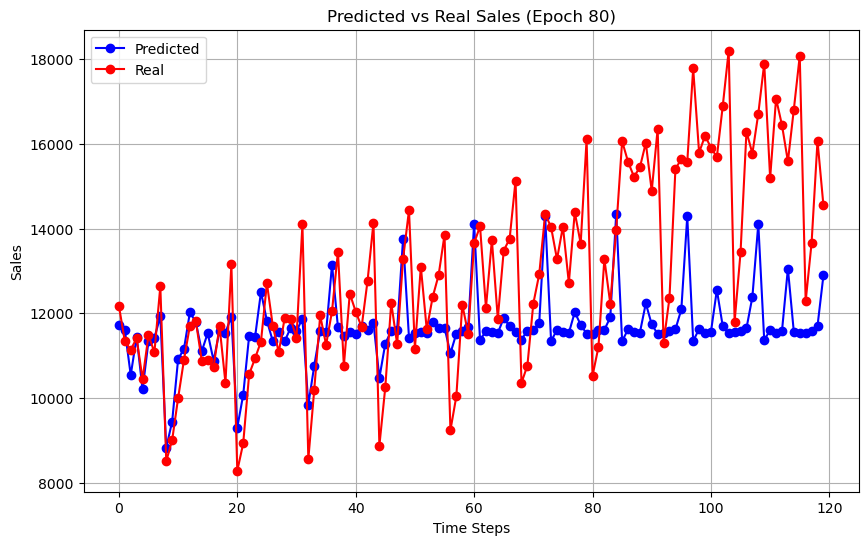

Epoch 82, Predicting loss improved to 0.014724
Epoch 83, Predicting loss improved to 0.013991
Epoch 86, Predicting loss improved to 0.012424
Epoch 90/150, Train Loss: 0.001091, Forecasted data's Loss: 0.017106


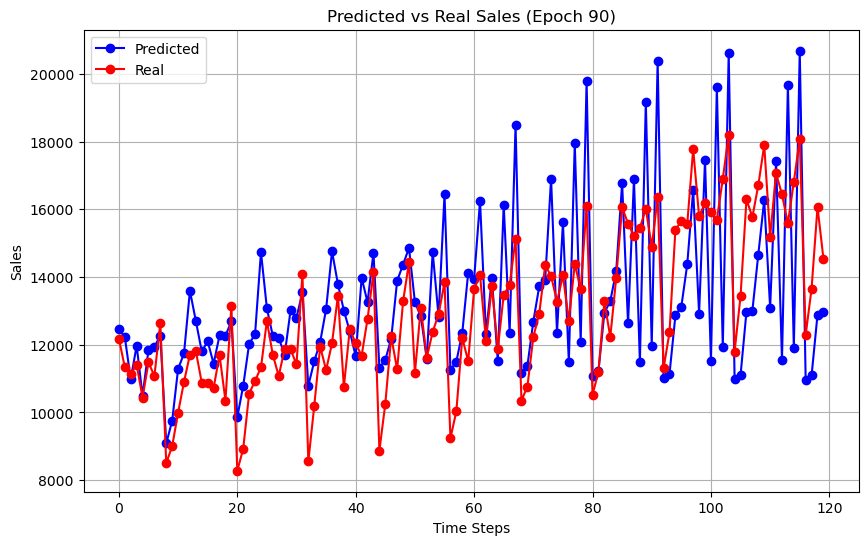

Epoch 93, Predicting loss improved to 0.010350
Epoch 100/150, Train Loss: 0.001069, Forecasted data's Loss: 0.039072


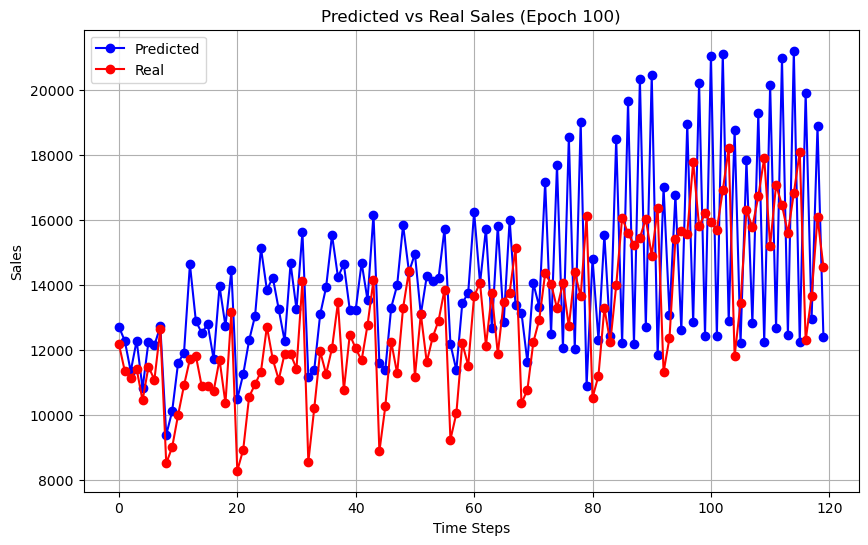

Epoch 110/150, Train Loss: 0.001107, Forecasted data's Loss: 0.060178


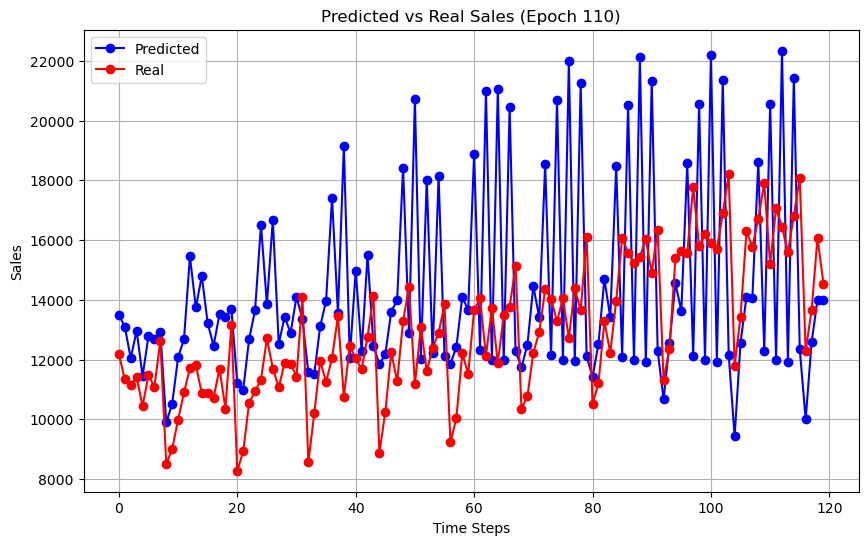

Epoch 120/150, Train Loss: 0.000934, Forecasted data's Loss: 0.019623


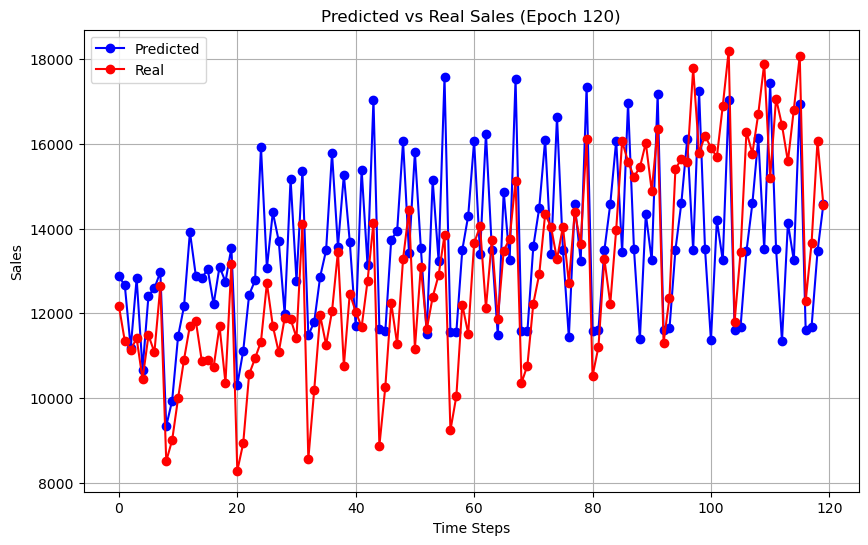

Epoch 130/150, Train Loss: 0.000900, Forecasted data's Loss: 0.029060


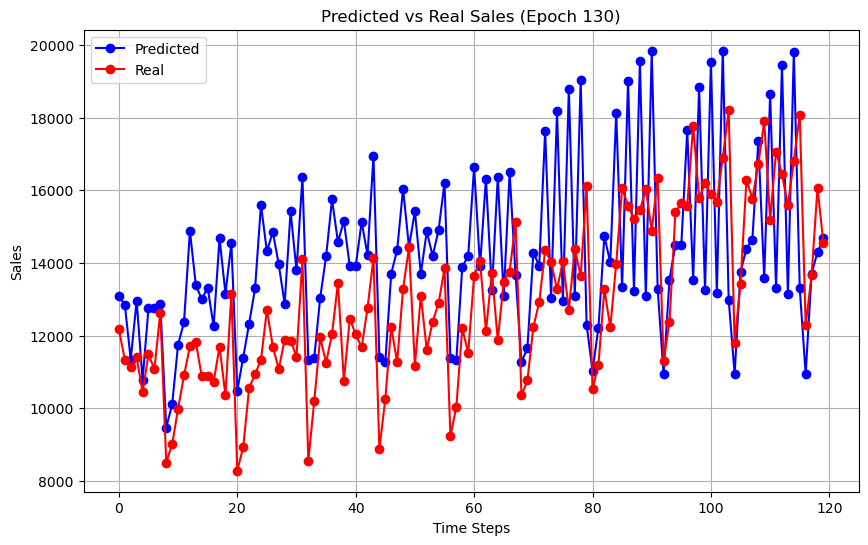

Epoch 140/150, Train Loss: 0.000936, Forecasted data's Loss: 0.024822


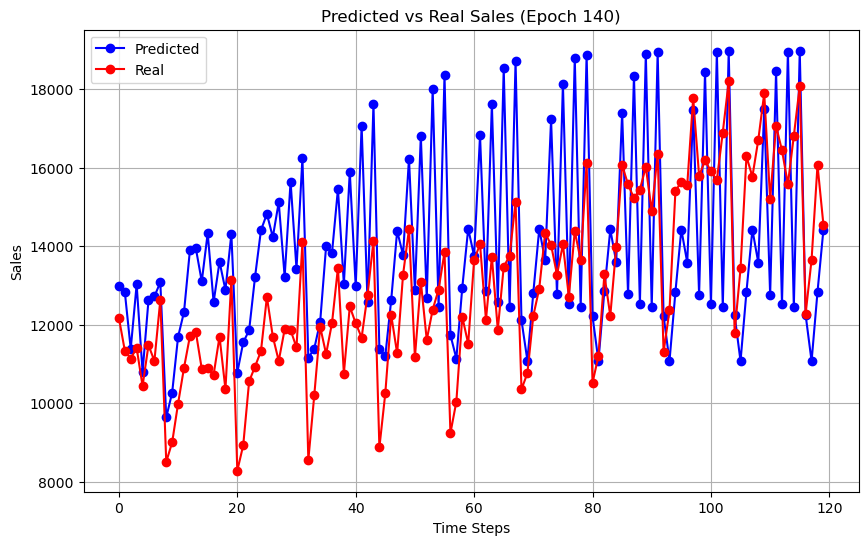

Epoch 150/150, Train Loss: 0.000950, Forecasted data's Loss: 0.035069


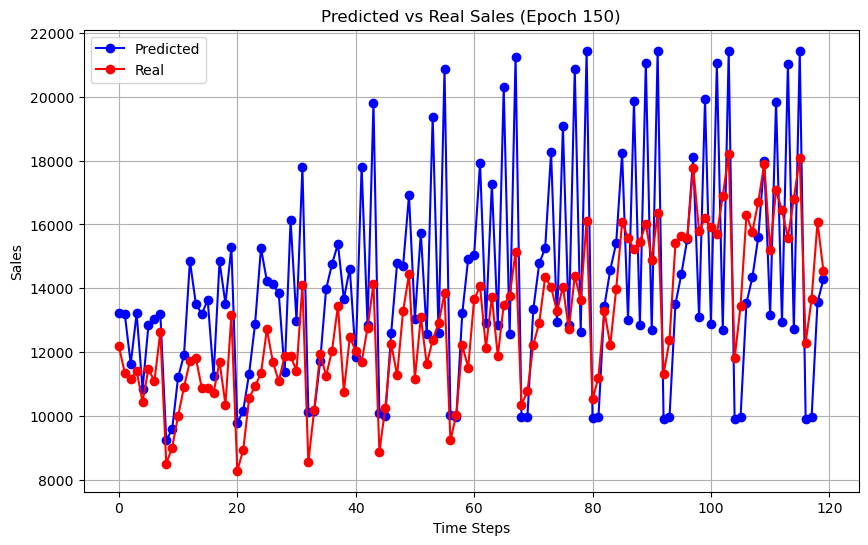

In [164]:
import matplotlib.pyplot as plt

# Training + Future Prediction
n_epochs = 150
future = 120
losses = []
best_loss = float('inf')

scaled_data = X_scaled.numpy().flatten()
train_set = X_scaled[:-(future)].flatten()

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    # Training LSTM
    for seq, label in train:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        y_pred = model(seq)
        loss = Loss(y_pred, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train)
    losses.append(avg_loss)

    # Forecasting loop
    model.eval()
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_size),
                            torch.zeros(1, 1, model.hidden_size))
            next_val = model(seq).item()
            preds.append(next_val)

    predicted_series = torch.FloatTensor(preds[-future:])
    true_future = torch.FloatTensor(scaled_data[-future:])
    forecast_loss = Loss(predicted_series, true_future)

    if forecast_loss.item() < best_loss:
        best_loss = forecast_loss.item()
        model_path = 'models/alcohol.pth'
        checkpoint = {'model_state_dict': model.state_dict()}
        torch.save(checkpoint, model_path)
        print(f"Epoch {epoch+1}, Predicting loss improved to {best_loss:.6f}")
##Show each plot for each 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_loss:.6f}, Forecasted data's Loss: {forecast_loss.item():.6f}")

        # Plotting every 10 epochs
        predicted_actual_values = scaler.inverse_transform(
            np.array(preds[-future:]).reshape(-1, 1))
        real_values = scaler.inverse_transform(
            scaled_data[-future:].reshape(-1, 1))

        plt.figure(figsize=(10, 6))
        plt.plot(range(future), predicted_actual_values, label='Predicted', color='blue', linestyle='-', marker='o')
        plt.plot(range(future), real_values, label='Real', color='red', linestyle='-', marker='o')
        plt.xlabel('Time Steps')
        plt.ylabel('Sales')
        plt.title(f'Predicted vs Real Sales (Epoch {epoch+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

plt.show()


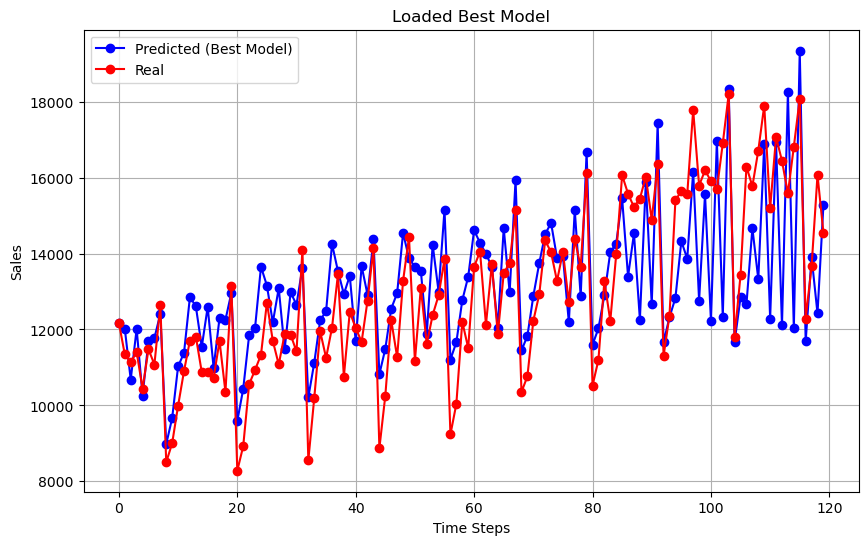

In [165]:
# Load the best model weights
checkpoint = torch.load('models/alcohol.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Forecasting using the best model
preds = train_set[-window_size:].tolist()
for f in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        next_val = model(seq).item()
        preds.append(next_val)

# Inverse transform for plotting
predicted_actual_values = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))
real_values = scaler.inverse_transform(scaled_data[-future:].reshape(-1, 1))

# Plot best prediction
plt.figure(figsize=(10, 6))
plt.plot(range(future), predicted_actual_values, label='Predicted (Best Model)', color='blue', linestyle='-', marker='o')
plt.plot(range(future), real_values, label='Real', color='red', linestyle='-', marker='o')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.title('Loaded Best Model')
plt.legend()
plt.grid(True)
plt.show()